In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

In [2]:
# Load Data
data = pd.read_csv('data1.csv')

# Check the first 5 rows
print("Data Preview:")
print(data.head())


Data Preview:
       Frequency         Z     Deg       Z.1   Deg.1       Z.2   Deg.2  \
0      10.000000   85042.0 -76.231   89189.0 -77.743   90240.0 -77.253   
1  378314.728446  138389.0 -14.992  132932.0 -15.101  130529.0 -15.183   
2  366799.267633  138709.0 -15.037  133246.0 -15.163  130821.0 -15.254   
3  355634.324069  139043.0 -15.088  133551.0 -15.234  131141.0 -15.332   
4  344809.228416  139379.0 -15.154  133867.0 -15.314  131457.0 -15.421   

     Z_mean  Z_median  Z_weighted_avg  Z_geometric_mean  Z_harmonic_mean  \
0   91131.9   91686.0         91131.9      91095.665907     91058.667853   
1  130343.4  128931.5        130343.4     130310.118788    130277.768358   
2  130646.0  129233.5        130646.0     130612.650599    130580.234047   
3  130958.3  129543.0        130958.3     130924.892367    130892.420262   
4  131275.8  129860.5        131275.8     131242.344844    131209.826901   

   Deg_mean  Deg_median  Deg_weighted_avg    label  
0  -77.6886     -77.820        

Training the model

In [3]:
# Separate features and target label
X = data.drop(columns=['label'])  # Features
y = data['label']                 # Target

# Encode the target label if it's categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape Input Data for Transformer (Batch, Sequence, Features)
# Sequence length = 1 (each data point is a single "time-step")
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train: (58800, 1, 15)
Shape of y_train: (58800,)


Defining a transformer

In [4]:
# Build the Transformer Model
class TransformerModel(tf.keras.Model):
    def __init__(self, num_classes, d_model=64, num_heads=4, ff_dim=128):
        super(TransformerModel, self).__init__()
        self.input_layer = tf.keras.layers.Dense(d_model, activation="relu")
        self.transformer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(d_model)
        ])
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
    
    def call(self, inputs):
        x = self.input_layer(inputs)
        attn_output = self.transformer(x, x)
        x = x + attn_output  # Residual Connection
        x = self.ffn(x) + x  # Another Residual Connection
        x = self.global_avg_pool(x)
        return self.output_layer(x)


Initiating and compiling the model

In [5]:
# Instantiate the model
num_classes = len(np.unique(y))
model = TransformerModel(num_classes=num_classes)

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Model Summary
model.build(input_shape=(None, 1, X_train.shape[2]))
print("Model Summary:")
model.summary()


Model Summary:


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'transformer_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention            │ ?                      │   0 (unbuilt) │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model training

In [6]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.0793 - loss: 3.3517 - val_accuracy: 0.1329 - val_loss: 2.9129
Epoch 2/20
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.1554 - loss: 2.8089 - val_accuracy: 0.1868 - val_loss: 2.6370
Epoch 3/20
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - accuracy: 0.2052 - loss: 2.5659 - val_accuracy: 0.2535 - val_loss: 2.4066
Epoch 4/20
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - accuracy: 0.2567 - loss: 2.3706 - val_accuracy: 0.2786 - val_loss: 2.2602
Epoch 5/20
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.2993 - loss: 2.2148 - val_accuracy: 0.3157 - val_loss: 2.1444
Epoch 6/20
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.3210 - loss: 2.1100 - val_accuracy: 0.3717 - val_loss: 1.9910
Epoch 7/20
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.3609 - loss: 2.0019 - val_accuracy: 0.3692 - val_loss: 1.9797
Epoch 8/20
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.3847 -

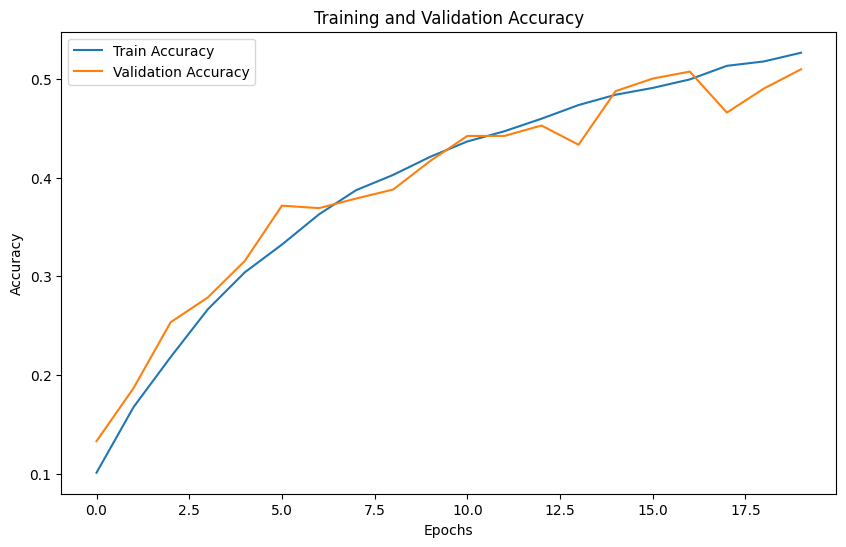

In [7]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Model evaluation

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5153 - loss: 1.4969
Test Loss: 1.5138
Test Accuracy: 0.5099


Label Distribution:
label
A_10-3     3000
B_10-7     2500
C_10-3     2500
C_10-4     2500
C_10-5     2500
B_10-8     2500
A_10-7     2500
A_10-4     2500
A_10-5     2500
A_10-6     2500
B_10-3     2500
A_10-8     2500
B_10-4     2500
C_10-6     2500
C_10-7     2500
C_10-8     2500
D_10-3     2500
D_10-4     2500
D_10-5     2500
D_10-7     2500
D_10-8     2500
B_10-5     2500
B_10-6     2500
D_10-6     2000
AC_10-8    1000
AC_10-3    1000
AC_10-5    1000
AC_10-4    1000
AC_10-7    1000
AB_10-3     500
BD_10-6     500
BD_10-5     500
BD_10-3     500
AB_10-4     500
AB_10-5     500
AB_10-6     500
AB_10-7     500
AB_10-8     500
BD_10-7     500
BD_10-8     500
CD_10-3     500
CD_10-4     500
CD_10-5     500
CD_10-6     500
CD_10-7     500
CD_10-8     500
Name: count, dtype: int64


C:\Users\Dell\AppData\Local\Temp\ipykernel_11192\3454399623.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


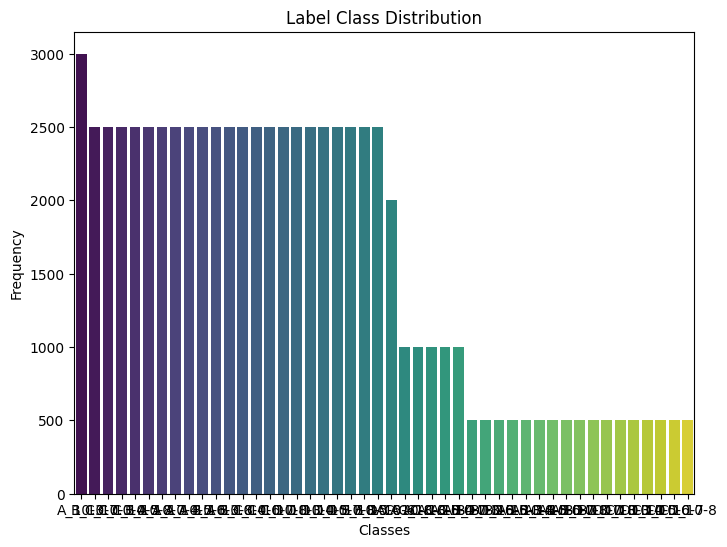

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check label distribution
label_counts = data['label'].value_counts()
print("Label Distribution:")
print(label_counts)

# Visualize class balance
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Label Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()


In [10]:
from imblearn.over_sampling import SMOTE

# Oversampling minority classes using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("Original Shape:", X.shape, y.shape)
print("Resampled Shape:", X_resampled.shape, y_resampled.shape)

# Split resampled data into train-test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Reshape for Transformer input
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


Original Shape: (73500, 15) (73500,)
Resampled Shape: (138000, 15) (138000,)


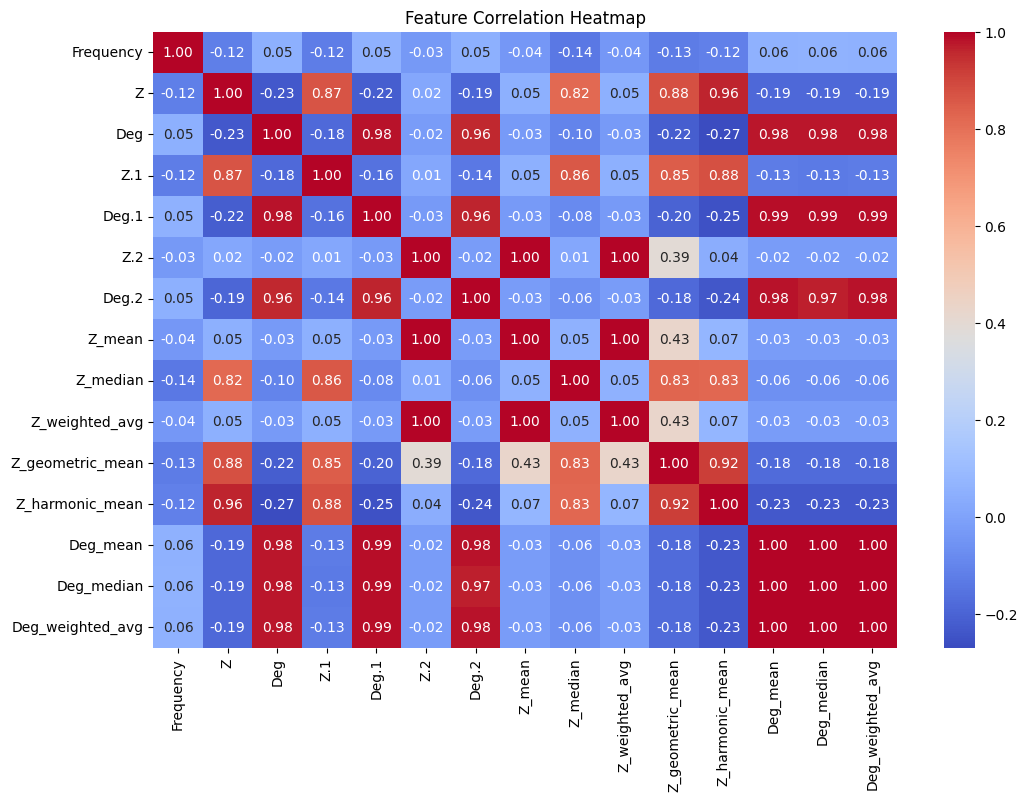

In [12]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Check correlations
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [13]:
# Remove highly correlated features
threshold = 0.9  # Correlation threshold
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > threshold)]

print("Highly Correlated Features to Drop:", high_corr_features)

# Drop highly correlated features
X_reduced = data.drop(columns=high_corr_features + ['label'])
y = data['label']

# Standardize reduced features
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(X_reduced_scaled, y, test_size=0.2, random_state=42)


Highly Correlated Features to Drop: ['Deg.1', 'Deg.2', 'Z_mean', 'Z_weighted_avg', 'Z_harmonic_mean', 'Deg_mean', 'Deg_median', 'Deg_weighted_avg']


In [17]:
print(X_train.shape)

(58800, 7)


In [18]:
print(len(data.columns[:-1]))


15


In [19]:
# Check the correct number of column names
column_names = data.columns[:X_train.shape[1]]  # Select the first 'X_train.shape[1]' columns

# Convert X_train and X_test back to DataFrames
X_train_df = pd.DataFrame(X_train, columns=column_names)
X_test_df = pd.DataFrame(X_test, columns=column_names)

In [20]:
from sklearn.preprocessing import LabelEncoder

# Identify non-numeric columns
non_numeric_columns = X_train_df.select_dtypes(include=['object']).columns
print("Non-Numeric Columns:", non_numeric_columns)

# Encode non-numeric columns using LabelEncoder
label_encoder = LabelEncoder()
for col in non_numeric_columns:
    X_train_df[col] = label_encoder.fit_transform(X_train_df[col])
    X_test_df[col] = label_encoder.transform(X_test_df[col])

print("Updated X_train:")
print(X_train_df.head())


Non-Numeric Columns: Index([], dtype='object')
Updated X_train:
   Frequency         Z       Deg       Z.1     Deg.1       Z.2     Deg.2
0  -0.385530 -0.394776 -0.197473 -0.417305 -0.091830 -0.461446 -0.435122
1  -0.351933 -0.510396 -0.633071 -0.518700 -0.093853 -0.563781 -0.542478
2   2.680342 -0.423954  0.239095 -0.435172 -0.091945 -0.479478 -0.452915
3  -0.385535 -0.385150 -0.172632 -0.371871 -0.091432 -0.442861 -0.410019
4  -0.384645 -0.503912  1.445600 -0.511556 -0.093664 -0.556571 -0.534740


In [22]:
import numpy as np
import tensorflow as tf

# Convert DataFrames back to numpy arrays
X_train_final = X_train_df.to_numpy()
X_test_final = X_test_df.to_numpy()

y_train_final = np.array(y_train)
y_test_final = np.array(y_test)

# Reshape input data for a Transformer model (or other DL models)
X_train_final = X_train_final.reshape(X_train_final.shape[0], 1, X_train_final.shape[1])
X_test_final = X_test_final.reshape(X_test_final.shape[0], 1, X_test_final.shape[1])

print("Final Shape of X_train:", X_train_final.shape)
print("Final Shape of X_test:", X_test_final.shape)


Final Shape of X_train: (58800, 1, 7)
Final Shape of X_test: (14700, 1, 7)


In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_final = label_encoder.fit_transform(y_train_final)
y_test_final = label_encoder.transform(y_test_final)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create a simple Sequential model for baseline testing
model = Sequential([
    InputLayer(input_shape=(X_train_final.shape[1], X_train_final.shape[2])),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Flatten(),
    Dense(len(np.unique(y_train)), activation='softmax')  # Adjust output neurons to match your classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(X_train_final, y_train_final,
                    validation_data=(X_test_final, y_test_final),
                    epochs=50, batch_size=32, callbacks=[reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_final, y_test_final)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/50


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1838/1838 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.0578 - loss: 3.5575 - val_accuracy: 0.0824 - val_loss: 3.3681 - learning_rate: 0.0010
Epoch 2/50
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.0818 - loss: 3.3560 - val_accuracy: 0.0945 - val_loss: 3.2448 - learning_rate: 0.0010
Epoch 3/50
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0962 - loss: 3.2417 - val_accuracy: 0.1040 - val_loss: 3.1638 - learning_rate: 0.0010
Epoch 4/50
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.0982 - loss: 3.1685 - val_accuracy: 0.1114 - val_loss: 3.1091 - learning_rate: 0.0010
Epoch 5/50
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.1071 - loss: 3.1181 - val_accuracy: 0.1195 - val_loss: 3.0678 - learning_rate: 0.0010
Epoch 6/50
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.1119 - loss: 3.0795 - val_accuracy: 0.1207 - val_loss: 3.0307 - learning_rate: 0.0010
Epoch 7/50
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.1186 - loss: 3